# Introduction: Home Credit Default Risk Competition

Ce cahier est destiné à ceux qui sont novices en matière de compétitions d'apprentissage automatique ou qui souhaitent une introduction en douceur au problème. J'évite volontairement de me lancer dans des modèles compliqués ou d'assembler de nombreuses données afin de montrer les bases de l'apprentissage automatique ! Tous les commentaires et suggestions sont les bienvenus.

Dans ce carnet, nous allons jeter un premier coup d'œil à la compétition d'apprentissage automatique sur le risque de défaut de Home Credit, actuellement hébergée sur Kaggle. L'objectif de ce concours est d'utiliser les données historiques des demandes de prêt pour prédire si un demandeur sera en mesure de rembourser un prêt. Il s'agit d'une tâche standard de classification supervisée :

* __Supervisé__ : Les étiquettes sont incluses dans les données d'entraînement et l'objectif est d'entraîner un modèle qui apprend à prédire les étiquettes à partir des caractéristiques.
* __Classification__ : L'étiquette est une variable binaire, 0 (remboursera le prêt à temps), 1 (aura des difficultés à rembourser le prêt).


# Data

Les données sont fournies par [Home Credit] (http://www.homecredit.net/about-us.aspx), un service dédié à la fourniture de lignes de crédit (prêts) à la population non bancarisée. Prédire si un client remboursera ou non un prêt ou s'il rencontrera des difficultés est un besoin commercial essentiel. Home Credit organise ce concours sur Kaggle pour voir quel type de modèles la communauté de l'apprentissage automatique peut développer pour l'aider dans cette tâche.

Il existe 7 sources de données différentes:

* `application_train`/`application_test`: les données principales d'entraînement et de test avec des informations sur chaque demande de prêt chez Home Credit. Chaque prêt a sa propre ligne et est identifié par la caractéristique `SK_ID_CURR`. Les données de la demande d'entraînement sont accompagnées de la caractéristique `TARGET` indiquant 0 : le prêt a été remboursé ou 1 : le prêt n'a pas été remboursé.
* `bureau`: données concernant les crédits antérieurs du client auprès d'autres institutions financières. Chaque crédit antérieur a sa propre ligne dans le bureau, mais un prêt dans les données de la demande peut avoir plusieurs crédits antérieurs.
* `bureau_balance`: données mensuelles concernant les crédits antérieurs dans bureau. Chaque ligne correspond à un mois d'un crédit antérieur, et un seul crédit antérieur peut avoir plusieurs lignes, une pour chaque mois de la durée du crédit.
* `previous_application`: demandes antérieures de prêts auprès de Home Credit de clients ayant des prêts dans les données de la demande. Chaque prêt en cours dans les données de la demande peut avoir plusieurs prêts antérieurs. Chaque demande antérieure a une ligne et est identifiée par la caractéristique `SK_ID_PREV`.
* `POS_CASH_BALANCE`: données mensuelles sur les prêts au point de vente ou les prêts au comptant que les clients ont eus avec Home Credit. Chaque ligne correspond à un mois d'un prêt au point de vente ou d'un prêt au comptant antérieur, et un seul prêt antérieur peut avoir plusieurs lignes.
* `credit_card_balance`: données mensuelles sur les cartes de crédit que les clients ont déjà eues avec Home Credit. Chaque ligne correspond à un mois de solde de carte de crédit, et une seule carte de crédit peut avoir plusieurs lignes.
* `installments_payment`: historique des paiements pour les prêts antérieurs chez Home Credit. Il y a une ligne pour chaque paiement effectué et une ligne pour chaque paiement manqué.

Ce diagramme montre comment toutes les données sont liées :

![image](https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png)

De plus, on nous fournit les définitions de toutes les colonnes (dans `HomeCredit_columns_description.csv`) et un exemple du fichier de soumission attendu.

Dans ce carnet, nous nous en tiendrons à utiliser uniquement les données de formation et de test de l'application principale. Bien que nous devions utiliser toutes les données si nous voulions avoir un espoir de participer sérieusement à la compétition, nous nous en tiendrons pour l'instant à un seul fichier, ce qui devrait être plus facile à gérer. Cela nous permettra d'établir une base de référence que nous pourrons ensuite améliorer. Dans ce genre de projet, il est préférable de comprendre le problème petit à petit plutôt que de s'y plonger complètement et de s'y perdre !

## Metric: ROC AUC

Une fois que nous avons compris les données (la lecture des [descriptions des colonnes] (https://www.kaggle.com/c/home-credit-default-risk/data) nous aide énormément), nous devons comprendre la métrique par laquelle notre soumission est jugée. Dans le cas présent, il s'agit d'une mesure de classification courante connue sous le nom d'indice [Receiver Operating Characteristic Area Under the Curve (ROC AUC, also sometimes called AUROC)](https://stats.stackexchange.com/questions/132777/what-does-auc-stand-for-and-what-is-it).

Le ROC AUC peut sembler intimidant, mais il est relativement simple une fois que l'on a assimilé les deux concepts individuels. L'AUC [Reciever Operating Characteristic (ROC) curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) représente graphiquement le taux de vrais positifs par rapport au taux de faux positifs :

![image](http://www.statisticshowto.com/wp-content/uploads/2016/08/ROC-curve.png)

Une seule ligne sur le graphique indique la courbe pour un seul modèle, et le déplacement le long d'une ligne indique le changement du seuil utilisé pour classer une instance positive. Le seuil commence à 0 en haut à droite et va jusqu'à 1 en bas à gauche. Une courbe située à gauche et au-dessus d'une autre courbe indique un meilleur modèle. Par exemple, le modèle bleu est meilleur que le modèle rouge, qui est meilleur que la ligne diagonale noire qui indique un modèle de devinettes aléatoires naïves.

The [Area Under the Curve (AUC)](http://gim.unmc.edu/dxtests/roc3.htm) s'explique par son nom ! Il s'agit simplement de l'aire sous la courbe ROC (c'est l'intégrale de la courbe). (C'est l'intégrale de la courbe.) Cette mesure est comprise entre 0 et 1, un meilleur modèle obtenant un score plus élevé. Un modèle qui se contente de deviner au hasard aura une aire sous la courbe ROC de 0,5.

Lorsque nous mesurons un classificateur en fonction de l'AUC ROC, nous ne générons pas des prédictions 0 ou 1, mais plutôt une probabilité entre 0 et 1. Cela peut être déroutant car nous aimons généralement penser en termes de précision, mais lorsque nous rencontrons des problèmes avec des classes déséquilibrées (nous verrons que c'est le cas), la précision n'est pas la meilleure métrique. Par exemple, si je voulais construire un modèle capable de détecter les terroristes avec une précision de 99,9999 %, je me contenterais de créer un modèle prédisant que chaque personne n'est pas un terroriste. Il est clair que cela ne serait pas efficace (le rappel serait nul) et nous utilisons des mesures plus avancées telles que la ROC AUC ou la [F1 score](https://en.wikipedia.org/wiki/F1_score) pour refléter plus précisément les performances d'un classificateur. Un modèle ayant une CUA ROC élevée aura également une précision élevée, mais la CUA ROC est plus élevée que la CUA ROC. [ROC AUC is a better representation of model performance.](https://datascience.stackexchange.com/questions/806/advantages-of-auc-vs-standard-accuracy)

Maintenant que nous connaissons le contexte des données que nous utilisons et la métrique à maximiser, commençons à explorer les données. Dans ce carnet, comme mentionné précédemment, nous nous en tiendrons aux principales sources de données et aux modèles simples sur lesquels nous pourrons nous appuyer dans nos travaux futurs.

Carnets de suivi

Pour ceux qui souhaitent continuer à travailler sur ce problème, j'ai une série de carnets de suivi :

* [Manual Feature Engineering Part One](https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering)
* [Manual Feature Engineering Part Two](https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering-p2)
* [Introduction to Automated Feature Engineering](https://www.kaggle.com/willkoehrsen/automated-feature-engineering-basics)
* [Advanced Automated Feature Engineering](https://www.kaggle.com/willkoehrsen/tuning-automated-feature-engineering-exploratory)
* [Feature Selection](https://www.kaggle.com/willkoehrsen/introduction-to-feature-selection)
* [Intro to Model Tuning: Grid and Random Search](https://www.kaggle.com/willkoehrsen/intro-to-model-tuning-grid-and-random-search)
* [Automated Model Tuning](https://www.kaggle.com/willkoehrsen/automated-model-tuning)
* [Model Tuning Results](https://www.kaggle.com/willkoehrsen/model-tuning-results-random-vs-bayesian-opt/notebook)


J'ajouterai d'autres carnets au fur et à mesure que je les termine ! Merci pour tous les commentaires !

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports

We are using a typical data science stack: `numpy`, `pandas`, `sklearn`, `matplotlib`.

In [2]:
pip install -q neptune psutil xgboost evidently shap dill mlflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.3/105.3 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 501.9/501.9 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 65.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 87.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.1/231.1 kB 17.2 MB/s eta 0:00:00

In [3]:
# pip install pipreqsnb

In [4]:
pip install -q --upgrade scikit-learn

In [5]:
import sklearn
print(sklearn.__version__)

1.5.2


In [6]:
%%time

# numpy and pandas for data manipulation
import numpy as np
import pandas as pd

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Change the working directory to the location of your module
os.chdir('/content/drive/MyDrive/OC_Data_Scientist/P7_Implémentez_un_modèle_de_scoring')
# Now you can import your module
import my_functions as MF
import shap
import dill

# Verify that you are running with an NVIDIA GPU
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found
CPU times: user 17.3 s, sys: 1.43 s, total: 18.8 s
Wall time: 1min 56s


In [7]:
colors = ['#F0EE60','#F0CB60','#7360F0','#666570','#707065','#000']

### **0.1 - Normalisation de l'affichage des graphiques**

In [8]:
# Defines title formatting
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.titlecolor'] = '#000'
plt.rcParams['axes.titlepad'] = 20
# Defines axis formatting
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelcolor'] = '#707065'
#Defines scale formatting
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['xtick.color'] = '#333'
plt.rcParams['ytick.color'] = '#333'

# Defines display of seaborn graphics
sns.set_theme(style="whitegrid", context="notebook", font_scale=1.2,
              rc={"axes.titlesize":16,
                  "axes.labelsize":10,
                  "xtick.labelsize":8,
                  "ytick.labelsize":8,
                  "xtick.color":"#333",
                  "ytick.color":"#333",
                  "axes.titlecolor":"#000",
                  "axes.labelcolor":"#707065"
                  })

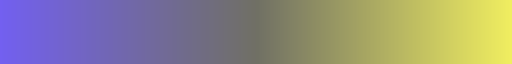

In [9]:
import matplotlib.colors as mcolors

# Define the heatmap color
first_color = "#7360F0"
under_color = "#707065"
over_color = "#F0EE60"
# Create a personal color map
colors = [first_color,under_color, over_color]
n_bins = 400
cmap_name = 'custom_colormap'
heatmap_color = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
heatmap_color

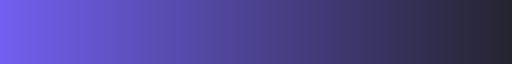

In [10]:
palette_b = sns.dark_palette("#7360F0", reverse=True, as_cmap=True)
palette_b

In [11]:
# Colour palette for the various graphics
n_colors = 10
palette_map = sns.color_palette("dark:#7360F0", n_colors=n_colors,as_cmap=False)
palette_map

[(0.14687478071527263, 0.142858782429367, 0.19089128921478496),
 (0.1802667694225845, 0.16851027483158645, 0.2732755444244187),
 (0.21365875812989632, 0.1941617672338059, 0.3556597996340525),
 (0.24824331786246934, 0.22072938436467604, 0.44098634967260175),
 (0.2816353065697812, 0.24638087676689546, 0.5233706048822355),
 (0.3162198663023542, 0.27294849389776565, 0.6086971549207848),
 (0.349611855009666, 0.2985999862999851, 0.6910814101304185),
 (0.384196414742239, 0.3251676034308552, 0.7764079601689677),
 (0.41758840344955084, 0.3508190958330747, 0.8587922153786015),
 (0.45098039215686275, 0.3764705882352941, 0.9411764705882353)]

## Read in Data

Tout d'abord, nous pouvons dresser la liste de tous les fichiers de données disponibles. Il y a au total 9 fichiers : 1 fichier principal pour la formation (avec la cible), 1 fichier principal pour le test (sans la cible), 1 fichier de soumission d'exemple et 6 autres fichiers contenant des informations supplémentaires sur chaque prêt.

In [12]:
path = "/content/drive/MyDrive/OC_Data_Scientist/P7_Implémentez_un_modèle_de_scoring/data/"
# List files available
print(os.listdir(path))

['installments_payments.csv', 'credit_card_balance.csv', 'bureau.csv', 'sample_submission.csv', 'POS_CASH_balance.csv', 'application_train.csv', 'HomeCredit_columns_description.csv', 'previous_application.csv', 'application_test.csv', 'bureau_balance.csv']


In [13]:
# Training data
app_train = pd.read_csv(f'{path}application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


Les données d'apprentissage comportent 307511 observations (chacune étant un prêt distinct) et 122 caractéristiques (variables), y compris la "cible" (l'étiquette que nous voulons prédire).

In [14]:
# Testing data features
app_test = pd.read_csv(f'{path}application_test.csv')
print('Testing data shape: ', app_test.shape)
app_test.head()

Testing data shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


L'ensemble de test est considérablement plus petit et ne comporte pas de colonne "TARGET".

# Exploratory Data Analysis

L'analyse exploratoire des données (EDA) est un processus ouvert dans le cadre duquel nous calculons des statistiques et établissons des chiffres afin de trouver des tendances, des anomalies, des modèles ou des relations dans les données. L'objectif de l'EDA est d'apprendre ce que nos données peuvent nous dire. Elle commence généralement par une vue d'ensemble, puis se concentre sur des domaines spécifiques au fur et à mesure que nous trouvons des zones intrigantes dans les données. Les résultats peuvent être intéressants en eux-mêmes ou être utilisés pour éclairer nos choix de modélisation, par exemple en nous aidant à décider des caractéristiques à utiliser.

## Examine the Distribution of the Target Column

La cible est ce que l'on nous demande de prédire : soit un 0 pour le prêt a été remboursé à temps, soit un 1 indiquant que le client a eu des difficultés de paiement. Nous pouvons d'abord examiner le nombre de prêts entrant dans chaque catégorie.

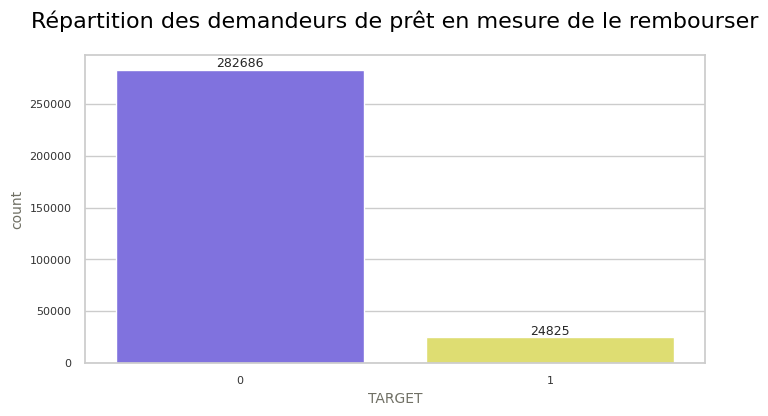

In [15]:
count_target = pd.DataFrame(app_train['TARGET'].astype("int8").value_counts()).reset_index()

plt.figure(figsize=(8,4))
# Création de l'histogramme en utilisant seaborn
# sns.histplot(app_train['TARGET'].astype(int), bins=2, kde=False)
ax = sns.barplot(x=count_target['TARGET'], y=count_target['count'], palette=["#7360F0","#F0EE60"])

# Ajouter les annotations sur chaque barre
for i in ax.containers:
    ax.bar_label(i, fmt='%d', fontsize=9)

plt.title('Répartition des demandeurs de prêt en mesure de le rembourser')
# Afficher le graphique
plt.show()
del count_target
plt.close()

Ces informations nous permettent de constater qu'il s'agit d'un [_imbalanced class problem_](http://www.chioka.in/class-imbalance-problem/). Il y a beaucoup plus de prêts remboursés à temps que de prêts non remboursés. Lorsque nous utiliserons des modèles d'apprentissage automatique plus sophistiqués, nous pourrons [weight the classes](http://xgboost.readthedocs.io/en/latest/parameter.html) par leur représentation dans les données afin de refléter ce déséquilibre.

## Examine Missing Values

Nous pouvons ensuite examiner le nombre et le pourcentage de valeurs manquantes dans chaque colonne.

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


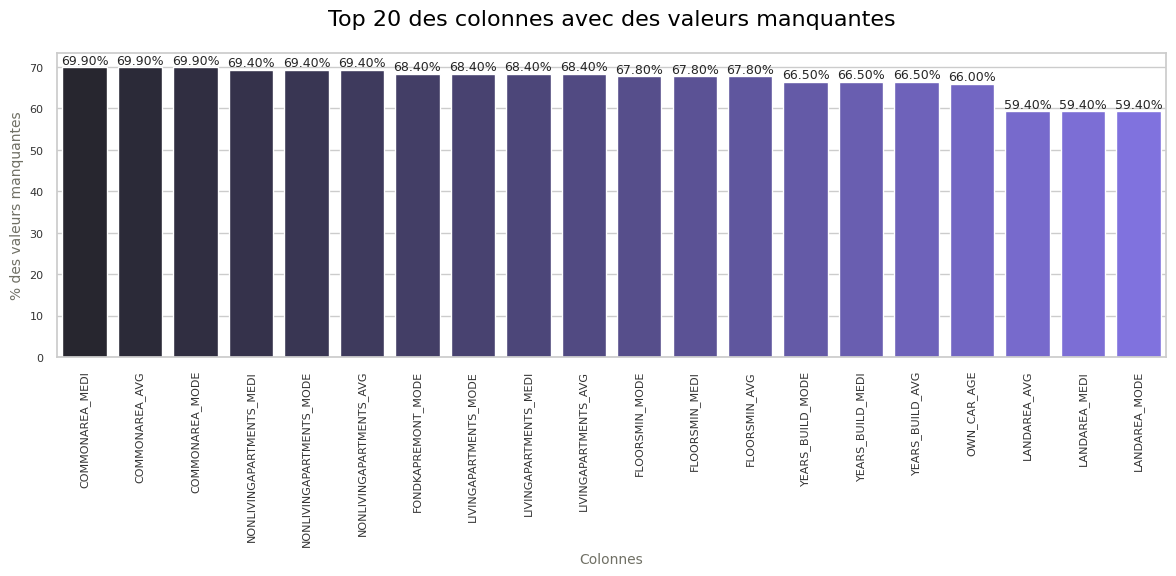

In [16]:
# Missing values statistics
missing_values = MF.missing_values_table(app_train)
# Filtrer les 20 premières colonnes avec le plus de valeurs manquantes
missing_values_top20 = missing_values.head(20)

# Colour palette for the various graphics
n_colors = len(missing_values_top20)
palette_map = sns.color_palette("dark:#7360F0", n_colors=n_colors,as_cmap=False)

plt.figure(figsize=(12, 6))
# Créer un graphique en barres avec Seaborn
ax = sns.barplot(x=missing_values_top20.index, y=missing_values_top20['% of Total Values'], palette=palette_map)

# Ajouter des annotations (valeurs au-dessus des barres)
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f%%', fontsize=9)

# Rotation de l'axe x pour lisibilité si les labels sont longs
plt.xticks(rotation=90)

# Ajout des titres et labels
plt.title('Top 20 des colonnes avec des valeurs manquantes')
plt.xlabel('Colonnes')
plt.ylabel('% des valeurs manquantes')

# Afficher le graphique
plt.tight_layout()
plt.show()

Lorsqu'il s'agira de construire nos modèles d'apprentissage automatique, nous devrons combler ces valeurs manquantes (ce que l'on appelle l'imputation). Par la suite, nous utiliserons des modèles tels que XGBoost qui peuvent [handle missing values with no need for imputation](https://stats.stackexchange.com/questions/235489/xgboost-can-handle-missing-data-in-the-forecasting-phase). Une autre option consisterait à supprimer les colonnes présentant un pourcentage élevé de valeurs manquantes, bien qu'il soit impossible de savoir à l'avance si ces colonnes seront utiles à notre modèle. Par conséquent, nous conserverons toutes les colonnes pour l'instant.

## Column Types

Examinons le nombre de colonnes de chaque type de données. `int64` et `float64` sont des variables numériques ([which can be either discrete or continuous](https://stats.stackexchange.com/questions/206/what-is-the-difference-between-discrete-data-and-continuous-data)). Les colonnes `objet` contiennent des chaînes de caractères et sont  [categorical features.](http://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/supporting-topics/basics/what-are-categorical-discrete-and-continuous-variables/) .

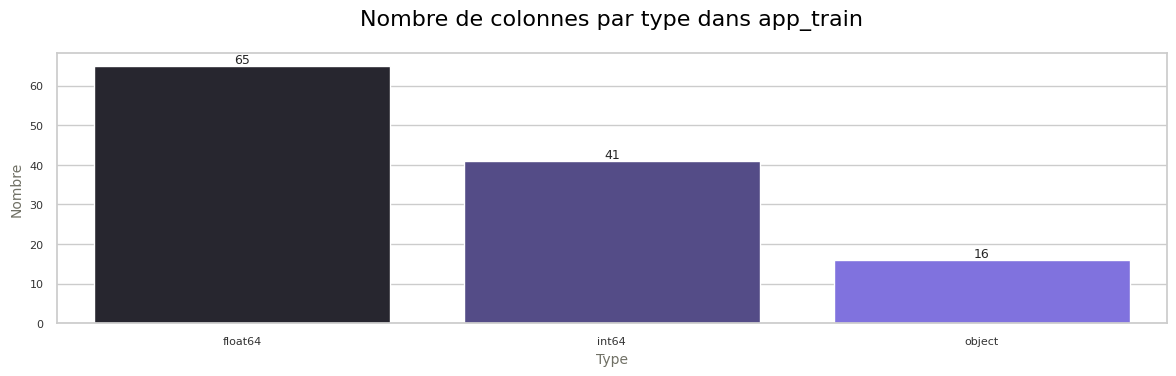

In [17]:
# Calculer le nombre de chaque type de colonne
column_types = app_train.dtypes.value_counts()

# Créer un DataFrame à partir de ces informations
column_types_df = column_types.reset_index()
column_types_df.columns = ['Type', 'Count']

# Colour palette for the various graphics
n_colors = len(column_types_df)
palette_map = sns.color_palette("dark:#7360F0", n_colors=n_colors, as_cmap=False)

plt.figure(figsize=(12, 4))
# Créer un graphique en barres avec Seaborn
ax = sns.barplot(x='Type', y='Count', data=column_types_df, palette=palette_map)

# Ajouter des annotations (valeurs au-dessus des barres)
for container in ax.containers:
    ax.bar_label(container, fmt='%d', fontsize=9)

# Ajout des titres et labels
plt.title('Nombre de colonnes par type dans app_train')
plt.ylabel('Nombre')

# Afficher le graphique
plt.tight_layout()
plt.show()

Examinons maintenant le nombre d'entrées uniques dans chacune des colonnes "objet" (catégorique).

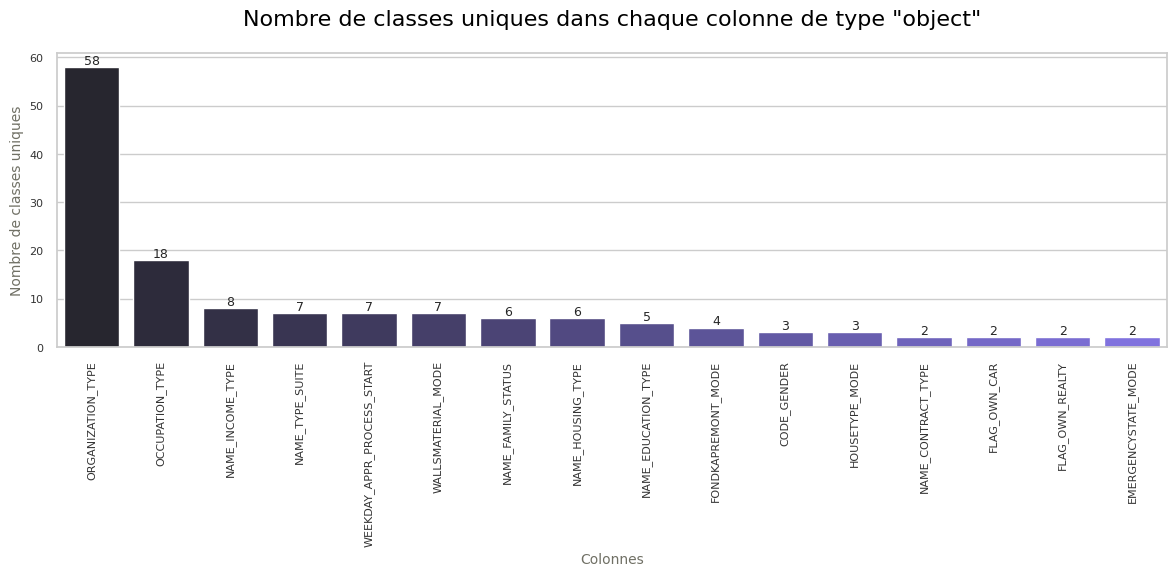

In [18]:
# Sélectionner les colonnes de type 'object' et compter les classes uniques
unique_classes = app_train.select_dtypes('object').apply(pd.Series.nunique, axis=0)

# Créer un DataFrame à partir de ces informations
unique_classes_df = unique_classes.reset_index()
unique_classes_df.columns = ['Column', 'Unique Classes']
unique_classes_df = unique_classes_df.sort_values(by='Unique Classes', ascending=False)

# Colour palette for the various graphics
n_colors = len(unique_classes_df)
palette_map = sns.color_palette("dark:#7360F0", n_colors=n_colors, as_cmap=False)

plt.figure(figsize=(12, 6))
# Créer un graphique en barres avec Seaborn
ax = sns.barplot(x='Column', y='Unique Classes', data=unique_classes_df, palette=palette_map)

# Ajouter des annotations (valeurs au-dessus des barres)
for container in ax.containers:
    ax.bar_label(container, fmt='%d', fontsize=9)

# Rotation des labels de l'axe x pour une meilleure lisibilité
plt.xticks(rotation=90)

# Ajout des titres et labels
plt.title('Nombre de classes uniques dans chaque colonne de type "object"')
plt.xlabel('Colonnes')
plt.ylabel('Nombre de classes uniques')

# Afficher le graphique
plt.tight_layout()
plt.show()

La plupart des variables catégorielles ont un nombre relativement faible d'entrées uniques. Nous devrons trouver un moyen de traiter ces variables catégorielles !

## Encoding Categorical Variables

Avant d'aller plus loin, nous devons traiter les variables catégorielles.  Un modèle d'apprentissage automatique ne peut malheureusement pas traiter les variables catégorielles (à l'exception de certains modèles tels que [LightGBM](http://lightgbm.readthedocs.io/en/latest/Features.html)). Nous devons donc trouver un moyen d'encoder (représenter) ces variables sous forme de nombres avant de les transmettre au modèle. Il y a deux façons principales d'effectuer ce processus :

* `Label encoding`: attribuer un nombre entier à chaque catégorie unique d'une variable catégorielle. Aucune nouvelle colonne n'est créée. Un exemple est donné ci-dessous

![image](https://raw.githubusercontent.com/WillKoehrsen/Machine-Learning-Projects/master/label_encoding.png)

* One-hot encoding: créer une nouvelle colonne pour chaque catégorie unique dans une variable catégorielle. Chaque observation reçoit un 1 dans la colonne de la catégorie correspondante et un 0 dans toutes les autres nouvelles colonnes.

![image](https://raw.githubusercontent.com/WillKoehrsen/Machine-Learning-Projects/master/one_hot_encoding.png)

Le problème du `Label encoding` est qu'il donne aux catégories un ordre arbitraire. La valeur attribuée à chacune des catégories est aléatoire et ne reflète aucun aspect inhérent à la catégorie. Dans l'exemple ci-dessus, le programmeur reçoit un 4 et le scientifique des données un 1, mais si nous refaisions le même processus, les étiquettes pourraient être inversées ou complètement différentes. L'affectation réelle des nombres entiers est arbitraire. Par conséquent, lorsque nous procédons au `Label encoding`, le modèle peut utiliser la valeur relative de la caractéristique (par exemple, programmeur = 4 et scientifique = 1) pour attribuer des poids, ce qui n'est pas ce que nous voulons. Si nous n'avons que deux valeurs uniques pour une variable catégorielle (telle que Homme/Femme), le `Label encoding` convient, mais pour plus de deux catégories uniques, le `One-hot encoding` est l'option la plus sûre.

Les mérites relatifs de ces approches font l'objet d'un débat, et certains modèles peuvent traiter sans problème des variables catégorielles codées par des étiquettes. [Here is a good Stack Overflow discussion](https://datascience.stackexchange.com/questions/9443/when-to-use-one-hot-encoding-vs-labelencoder-vs-dictvectorizor). Je pense (et ce n'est qu'une opinion personnelle) que pour les variables catégorielles comportant de nombreuses classes, le `One-hot encoding` est l'approche la plus sûre car elle n'impose pas de valeurs arbitraires aux catégories. Le seul inconvénient du `One-hot encoding` est que le nombre de caractéristiques (dimensions des données) peut exploser avec des variables catégorielles comportant de nombreuses catégories. Pour y remédier, nous pouvons effectuer un `One-hot encoding` suivi de [PCA](http://www.cs.otago.ac.nz/cosc453/student_tutorials/principal_components.pdf) ou autre [dimensionality reduction methods](https://www.analyticsvidhya.com/blog/2015/07/dimension-reduction-methods/) pour réduire le nombre de dimensions (tout en essayant de préserver l'information).

Dans ce carnet, nous utiliserons le `Label encoding` pour toutes les variables catégorielles ne comportant que deux catégories et le `One-hot encoding` pour toutes les variables catégorielles comportant plus de deux catégories. Il se peut que ce processus doive être modifié au fur et à mesure que nous avançons dans le projet, mais pour l'instant, nous allons voir où cela nous mène. (Nous n'utiliserons pas non plus de réduction de la dimensionnalité dans ce carnet, mais nous l'explorerons dans des itérations futures).

### Label Encoding and One-Hot Encoding

Mettons en place la politique décrite ci-dessus : pour toute variable catégorielle (`dtype == object`) avec 2 catégories uniques, nous utiliserons le `Label encoding`, et pour toute variable catégorielle avec plus de 2 catégories uniques, nous utiliserons le `One-hot encoding`.

Pour l'encodage des étiquettes, nous utilisons le Scikit-Learn `LabelEncoder` et pour le `One-hot encoding`, la fonction pandas `get_dummies(df)`.

In [19]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            print('Identified columns:', col)
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])

            # Keep track of how many columns were label encoded
            le_count += 1

print('%d columns were label encoded.' % le_count)

Identified columns: NAME_CONTRACT_TYPE
Identified columns: FLAG_OWN_CAR
Identified columns: FLAG_OWN_REALTY
3 columns were label encoded.


In [20]:
# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) > 2:
            print('Train identified columns:', col)
print('-'*20)
# Iterate through the columns
for col in app_test:
    if app_test[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_test[col].unique())) > 2:
            print('Train identified columns:', col)

# one-hot encoding of categorical variables
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Train identified columns: CODE_GENDER
Train identified columns: NAME_TYPE_SUITE
Train identified columns: NAME_INCOME_TYPE
Train identified columns: NAME_EDUCATION_TYPE
Train identified columns: NAME_FAMILY_STATUS
Train identified columns: NAME_HOUSING_TYPE
Train identified columns: OCCUPATION_TYPE
Train identified columns: WEEKDAY_APPR_PROCESS_START
Train identified columns: ORGANIZATION_TYPE
Train identified columns: FONDKAPREMONT_MODE
Train identified columns: HOUSETYPE_MODE
Train identified columns: WALLSMATERIAL_MODE
Train identified columns: EMERGENCYSTATE_MODE
--------------------
Train identified columns: NAME_TYPE_SUITE
Train identified columns: NAME_INCOME_TYPE
Train identified columns: NAME_EDUCATION_TYPE
Train identified columns: NAME_FAMILY_STATUS
Train identified columns: NAME_HOUSING_TYPE
Train identified columns: OCCUPATION_TYPE
Train identified columns: WEEKDAY_APPR_PROCESS_START
Train identified columns: ORGANIZATION_TYPE
Train identified columns: FONDKAPREMONT_MODE
T

### Aligning Training and Testing Data

Il doit y avoir les mêmes caractéristiques (colonnes) dans les données de formation et de test. L'encodage à chaud a créé plus de colonnes dans les données d'apprentissage parce qu'il y avait des variables catégorielles dont les catégories n'étaient pas représentées dans les données de test. Pour supprimer les colonnes des données d'apprentissage qui ne se trouvent pas dans les données de test, nous devons "aligner" les cadres de données. Tout d'abord, nous extrayons la colonne cible des données d'apprentissage (parce qu'elle n'est pas dans les données de test, mais nous devons conserver cette information). Quand nous faisons l'alignement, nous devons nous assurer de mettre `axis = 1` pour aligner les dataframes sur les colonnes et non sur les lignes !

In [21]:
train_labels = app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Add the target back in
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


Les ensembles de données de formation et de test ont désormais les mêmes caractéristiques, ce qui est nécessaire pour l'apprentissage automatique. Le nombre de caractéristiques a augmenté de manière significative en raison de l'encodage à une touche. À un moment donné, nous voudrons probablement essayer [dimensionality reduction (removing features that are not relevant)](https://en.wikipedia.org/wiki/Dimensionality_reduction) pour réduire la taille des ensembles de données.

## Back to Exploratory Data Analysis

### Anomalies

Les anomalies dans les données sont un problème que nous devons toujours surveiller lorsque nous faisons de l'EDA. Celles-ci peuvent être dues à des chiffres mal saisis, à des erreurs dans l'équipement de mesure ou à des mesures valables mais extrêmes. L'une des façons de détecter les anomalies de manière quantitative est d'examiner les statistiques d'une colonne à l'aide de la méthode `describe`. Les chiffres de la colonne `DAYS_BIRTH` sont négatifs car ils sont enregistrés par rapport à la demande de prêt en cours. Pour voir ces statistiques en années, nous pouvons multiplier par -1 et diviser par le nombre de jours dans une année :

In [22]:
(app_train['DAYS_BIRTH'] / -365).describe()

,DAYS_BIRTH
count,307511.000000
mean,43.936973
std,11.956133
min,20.517808
25%,34.008219
50%,43.150685
75%,53.923288
max,69.120548


Ces âges semblent raisonnables. Il n'y a pas de valeurs aberrantes pour l'âge, que ce soit à l'extrémité supérieure ou inférieure. Qu'en est-il des jours d'emploi ?

In [23]:
app_train['DAYS_EMPLOYED'].describe()

,DAYS_EMPLOYED
count,307511.000000
mean,63815.045904
std,141275.766519
min,-17912.000000
25%,-2760.000000
50%,-1213.000000
75%,-289.000000
max,365243.000000


Cela ne semble pas correct ! La valeur maximale (en plus d'être positive) est d'environ 1000 ans !

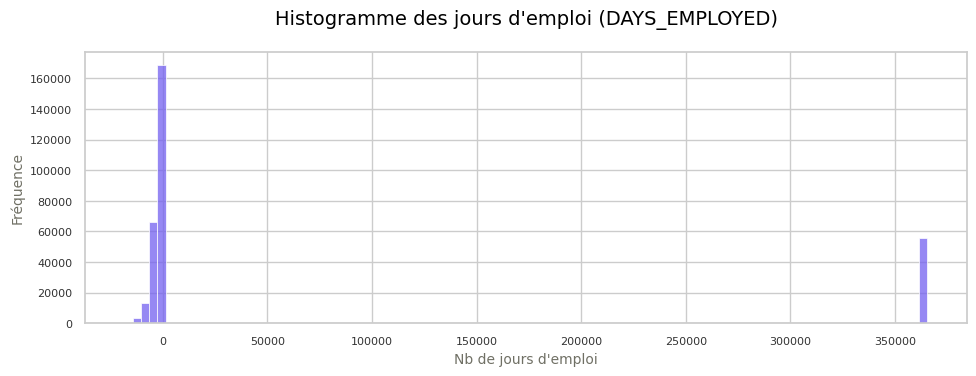

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
# Créer un histogramme avec Seaborn
sns.histplot(app_train['DAYS_EMPLOYED'], kde=False, bins=100, color='#7360F0')

# Ajouter un titre et un label pour l'axe x
plt.title('Histogramme des jours d\'emploi (DAYS_EMPLOYED)', fontsize=14)
plt.xlabel('Nb de jours d\'emploi')
plt.ylabel('Fréquence')

# Afficher le graphique
plt.tight_layout()
plt.show()

Par simple curiosité, nous allons regrouper les clients présentant des anomalies et voir s'ils ont tendance à avoir des taux de défaillance plus élevés ou plus faibles que le reste des clients.

In [25]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


Voilà qui est extrêmement intéressant ! Il s'avère que les anomalies ont un taux de défaillance plus faible.

Le traitement des anomalies dépend de la situation exacte et il n'existe pas de règles fixes. L'une des approches les plus sûres consiste à définir les anomalies comme des valeurs manquantes et à les compléter (à l'aide de l'imputation) avant l'apprentissage automatique. Dans ce cas, comme toutes les anomalies ont exactement la même valeur, nous voulons les compléter avec la même valeur au cas où tous ces prêts auraient quelque chose en commun. Les valeurs anormales semblent avoir une certaine importance, c'est pourquoi nous voulons indiquer au modèle d'apprentissage automatique si nous avons effectivement renseigné ces valeurs. Comme solution, nous allons remplir les valeurs anormales avec un nombre (`np.nan`) et ensuite créer une nouvelle colonne booléenne indiquant si la valeur était anormale ou non.

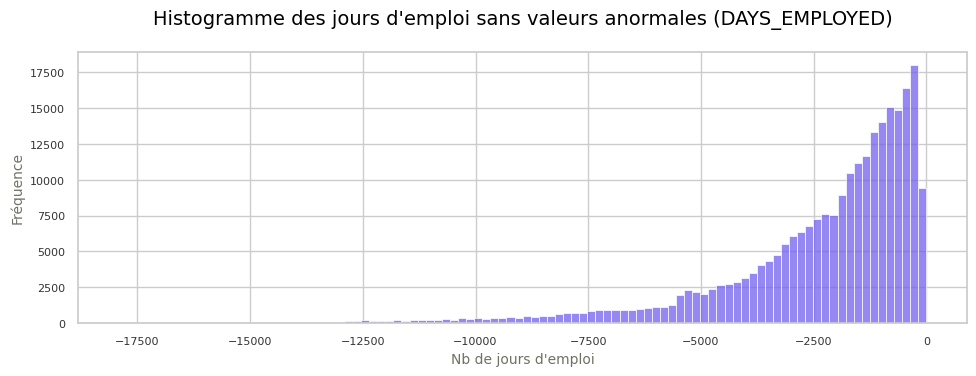

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Créer une colonne pour les valeurs anormales
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

# Remplacer les valeurs anormales (365243) par NaN
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)

plt.figure(figsize=(10, 4))
# Créer un histogramme avec Seaborn pour les jours d'emploi sans les valeurs anormales
sns.histplot(app_train['DAYS_EMPLOYED'].dropna(), kde=False, bins=100, color='#7360F0')

# Ajouter un titre et un label pour l'axe x
plt.title('Histogramme des jours d\'emploi sans valeurs anormales (DAYS_EMPLOYED)', fontsize=14)
plt.xlabel('Nb de jours d\'emploi')
plt.ylabel('Fréquence')

# Afficher le graphique
plt.tight_layout()
plt.show()

La distribution semble beaucoup plus conforme à ce que nous attendons, et nous avons également créé une nouvelle colonne pour indiquer au modèle que ces valeurs étaient à l'origine anormales (parce que nous devrons remplir les nans avec une valeur, probablement la médiane de la colonne). Les autres colonnes avec `DAYS` dans le cadre de données semblent être à peu près ce que nous attendons, sans valeurs aberrantes évidentes.

Il est très important de noter que tout ce que nous faisons sur les données d'entraînement, nous devons aussi le faire sur les données de test. Assurons-nous de créer la nouvelle colonne et de remplir la colonne existante avec `np.nan` dans les données de test.

In [27]:
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))

There are 9274 anomalies in the test data out of 48744 entries


### Correlations

Maintenant que nous avons traité les variables catégorielles et les valeurs aberrantes, poursuivons avec l'EDA. Une façon d'essayer de comprendre les données est de rechercher des corrélations entre les caractéristiques et la cible. Nous pouvons calculer le coefficient de corrélation de Pearson entre chaque variable et la cible en utilisant la méthode `.corr` dataframe.

Le coefficient de corrélation n'est pas la meilleure méthode pour représenter la "pertinence" d'une caractéristique, mais il nous donne une idée des relations possibles entre les données. Quelques-uns de ces coefficients de corrélation ont été calculés à partir des données de l'enquête. [general interpretations of the absolute value of the correlation coefficent](http://www.statstutor.ac.uk/resources/uploaded/pearsons.pdf) are:


* .00-.19 “very weak”
*  .20-.39 “weak”
*  .40-.59 “moderate”
*  .60-.79 “strong”
* .80-1.0 “very strong”


In [28]:
# Find correlations with the target and sort
correlations = app_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

Examinons quelques-unes des corrélations les plus significatives : la corrélation `DAYS_BIRTH` est la plus positive (sauf pour `TARGET` car la corrélation d'une variable avec elle-même est toujours de 1 !). En regardant la documentation, `DAYS_BIRTH` est l'âge en jours du client au moment du prêt en jours négatifs (pour une raison quelconque !). La corrélation est positive, mais la valeur de cette caractéristique est en fait négative, ce qui signifie que plus le client vieillit, moins il est susceptible de ne pas rembourser son prêt (c'est-à-dire la cible == 0). C'est un peu déroutant, nous prendrons donc la valeur absolue de la caractéristique et la corrélation sera négative.

### Effect of Age on Repayment

In [29]:
# Find the correlation of the positive days since birth and target
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830982694

Plus le client est âgé, plus il existe une relation linéaire négative avec la cible, ce qui signifie que plus les clients sont âgés, plus ils ont tendance à rembourser leurs prêts à temps.

Commençons par examiner cette variable. Tout d'abord, nous pouvons faire un histogramme de l'âge. L'axe des x sera exprimé en années pour rendre le graphique un peu plus compréhensible.

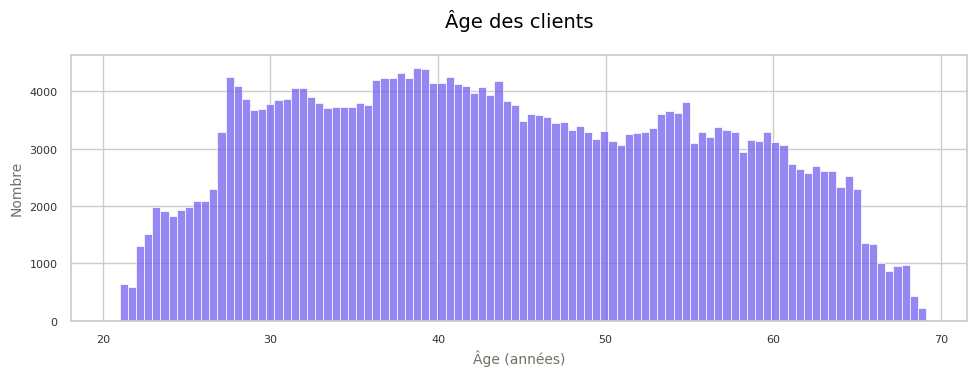

In [30]:
# Créer un histogramme avec Seaborn pour la distribution des âges
plt.figure(figsize=(10, 4))
sns.histplot(app_train['DAYS_BIRTH'] / 365, bins=100, color='#7360F0')

# Ajouter un titre et des labels
plt.title('Âge des clients', fontsize=14)
plt.xlabel('Âge (années)')
plt.ylabel('Nombre')

# Afficher le graphique
plt.tight_layout()
plt.show()

En soi, la distribution de l'âge ne nous apprend pas grand-chose, si ce n'est qu'il n'y a pas de valeurs aberrantes puisque tous les âges sont raisonnables. Pour visualiser l'effet de l'âge sur la cible, nous ferons ensuite une [graphe d'estimation de la densité du noyau](https://en.wikipedia.org/wiki/Kernel_density_estimation) (KDE) colorée par la valeur de la cible. [Le graphique de l'estimation de la densité du noyau montre la distribution d'une seule variable.](https://chemicalstatistician.wordpress.com/2013/06/09/exploratory-data-analysis-kernel-density-estimation-in-r-on-ozone-pollution-data-in-new-york-and-ozonopolis/) et peut être considéré comme un histogramme lissé (il est créé en calculant un noyau, généralement une gaussienne, à chaque point de données, puis en faisant la moyenne de tous les noyaux individuels pour développer une seule courbe lisse). Nous utiliserons le `kdeplot` de seaborn pour ce graphique.

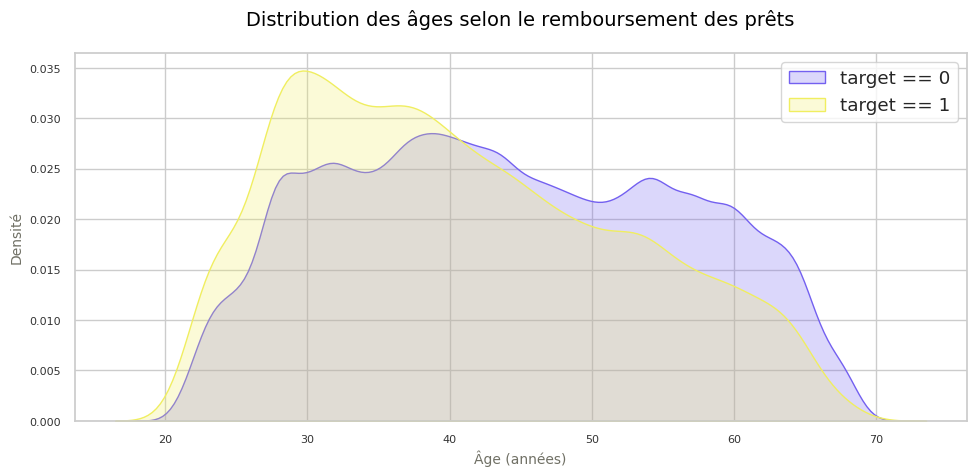

In [31]:
plt.figure(figsize=(10, 5))

# Tracé de la densité (KDE) pour les prêts remboursés à temps (TARGET == 0)
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label='target == 0', fill=True, color='#7360F0')

# Tracé de la densité (KDE) pour les prêts non remboursés à temps (TARGET == 1)
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label='target == 1', fill=True, color='#F0EE60')

# Étiquetage du graphique
plt.xlabel('Âge (années)')
plt.ylabel('Densité')
plt.title('Distribution des âges selon le remboursement des prêts', fontsize=14)
plt.legend()
plt.tight_layout()

# Afficher le graphique
plt.show()

La courbe de la cible == 1 penche vers l'extrémité la plus jeune de la fourchette. Bien qu'il ne s'agisse pas d'une corrélation significative (coefficient de corrélation de -0,07), cette variable sera probablement utile dans un modèle d'apprentissage automatique car elle affecte la cible. Examinons cette relation sous un autre angle : le taux moyen de non-remboursement des prêts par tranche d'âge.

Pour créer ce graphique, nous commençons par "découper" la catégorie d'âge en tranches de 5 ans chacune. Ensuite, pour chaque tranche, nous calculons la valeur moyenne de la cible, qui nous indique le ratio de prêts non remboursés dans chaque catégorie d'âge.

In [32]:
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [33]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


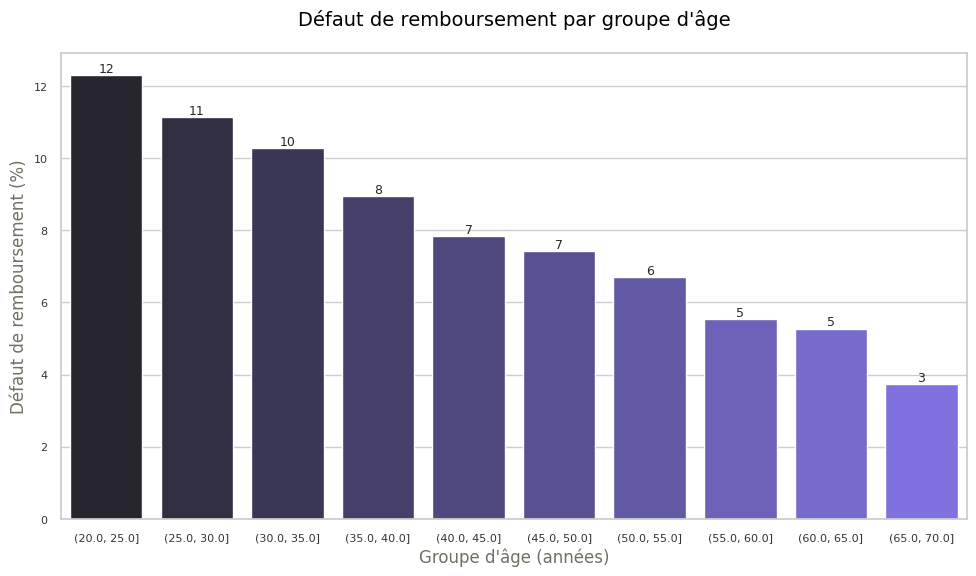

In [34]:
plt.figure(figsize=(10, 6))

# Convertir la Series en DataFrame
age_groups_df = age_groups[['TARGET']]

# Colour palette for the various graphics
n_colors = len(age_groups_df)
palette_map = sns.color_palette("dark:#7360F0", n_colors=n_colors, as_cmap=False)

# Créer un graphique à barres avec Seaborn
ax = sns.barplot(x=age_groups.index, y=100 * age_groups_df['TARGET'], data=age_groups_df, palette=palette_map)

# Ajouter des annotations (valeurs au-dessus des barres)
for container in ax.containers:
    ax.bar_label(container, fmt='%d', fontsize=9)

# Étiquetage du graphique
# plt.xticks(rotation=90)  # Rotation des étiquettes pour la lisibilité
plt.xlabel('Groupe d\'âge (années)', fontsize=12)
plt.ylabel('Défaut de remboursement (%)', fontsize=12)
plt.title('Défaut de remboursement par groupe d\'âge', fontsize=14)

# Afficher le graphique
plt.tight_layout()
plt.show()


La tendance est claire : les jeunes demandeurs sont plus susceptibles de ne pas rembourser le prêt ! Le taux de non-remboursement est supérieur à 10 % pour les trois groupes d'âge les plus jeunes et inférieur à 5 % pour le groupe le plus âgé.

Il s'agit d'une information qui pourrait être directement utilisée par la banque : étant donné que les jeunes clients sont moins susceptibles de rembourser le prêt, il conviendrait peut-être de leur fournir davantage de conseils ou d'astuces en matière de planification financière. Cela ne signifie pas que la banque doive discriminer les jeunes clients, mais il serait judicieux de prendre des mesures de précaution pour les aider à rembourser à temps.

### Exterior Sources

Les 3 variables ayant les plus fortes corrélations négatives avec la cible sont `EXT_SOURCE_1`, `EXT_SOURCE_2`, et `EXT_SOURCE_3`.
Selon la documentation, ces caractéristiques représentent un "score normalisé de la source de données externe". Je ne suis pas sûr de ce que cela signifie exactement, mais il pourrait s'agir d'une sorte d'évaluation de crédit cumulative réalisée à partir de nombreuses sources de données.

Examinons ces variables.

Tout d'abord, nous pouvons montrer les corrélations des caractéristiques `EXT_SOURCE` avec la cible et entre elles.

In [35]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


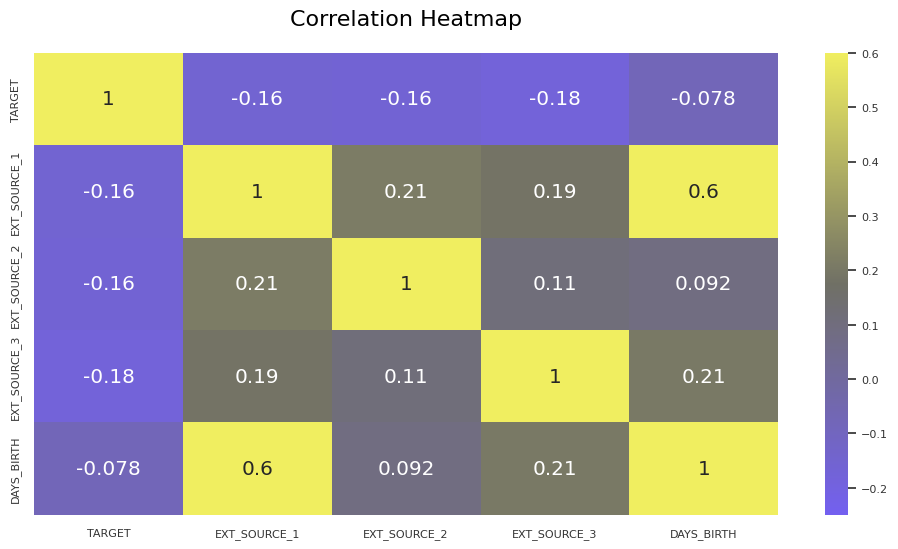

In [36]:
plt.figure(figsize = (12, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap=heatmap_color, vmin=-0.25, annot=True, vmax=0.6, )
plt.title('Correlation Heatmap');
plt.show()
plt.close()

Les trois caractéristiques `EXT_SOURCE` ont des corrélations négatives avec la cible, ce qui indique que plus la valeur de `EXT_SOURCE` augmente, plus le client est susceptible de rembourser le prêt. Nous pouvons également voir que `DAYS_BIRTH` est positivement corrélé avec `EXT_SOURCE_1`, ce qui indique que l'un des facteurs de ce score est peut-être l'âge du client.

Ensuite, nous pouvons regarder la distribution de chacune de ces caractéristiques colorée par la valeur de la cible. Cela nous permettra de visualiser l'effet de cette variable sur la cible.

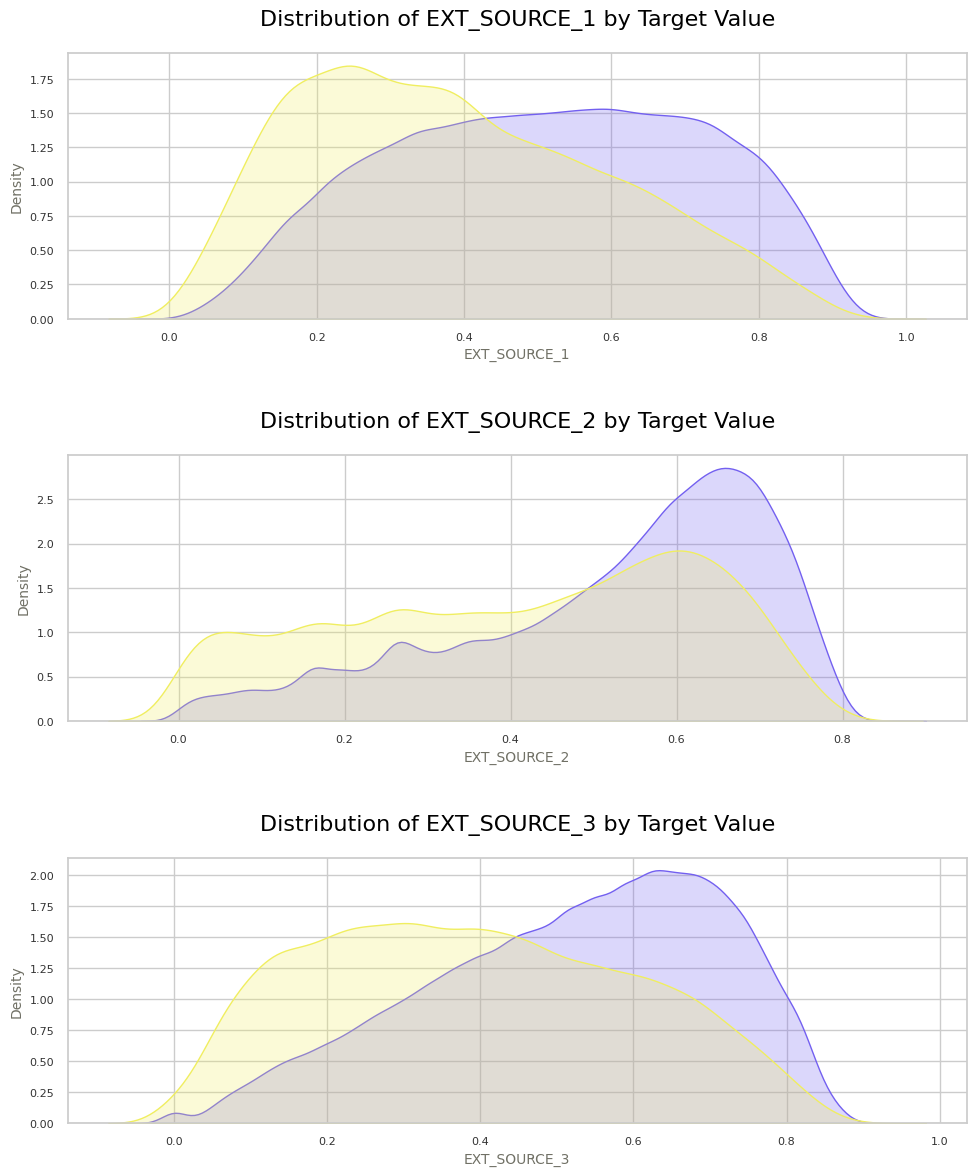

In [37]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):

    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0', fill=True, color='#7360F0')
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1', fill=True, color='#F0EE60')

    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');

plt.tight_layout(h_pad = 2.5)
plt.show()
plt.close()

`EXT_SOURCE_3` affiche la plus grande différence entre les valeurs de la cible. Nous pouvons clairement voir que cette caractéristique a une certaine relation avec la probabilité qu'un demandeur rembourse un prêt. La relation n'est pas très forte, en fait ils sont tous [considérée comme très faible](http://www.statstutor.ac.uk/resources/uploaded/pearsons.pdf), mais ces variables seront toujours utiles à un modèle d'apprentissage automatique pour prédire si un demandeur remboursera ou non un prêt dans les délais.

## Pairs Plot

En guise de dernier graphique exploratoire, nous pouvons établir un graphique de paires entre les variables `EXT_SOURCE` et la variable `DAYS_BIRTH`. Le [Pairs Plot](https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166) est un excellent outil d'exploration car il nous permet de voir les relations entre plusieurs paires de variables ainsi que les distributions de variables uniques. Ici, nous utilisons la bibliothèque de visualisation seaborn et la fonction PairGrid pour créer un diagramme de paires avec des diagrammes de dispersion dans le triangle supérieur, des histogrammes sur la diagonale et des diagrammes de densité de noyau en 2D et des coefficients de corrélation dans le triangle inférieur.

Si vous ne comprenez pas ce code, ce n'est pas grave ! Le traçage en Python peut être excessivement complexe, et pour tout ce qui dépasse les graphiques les plus simples, je trouve généralement une implémentation existante et j'adapte le code (ne vous répétez pas) !

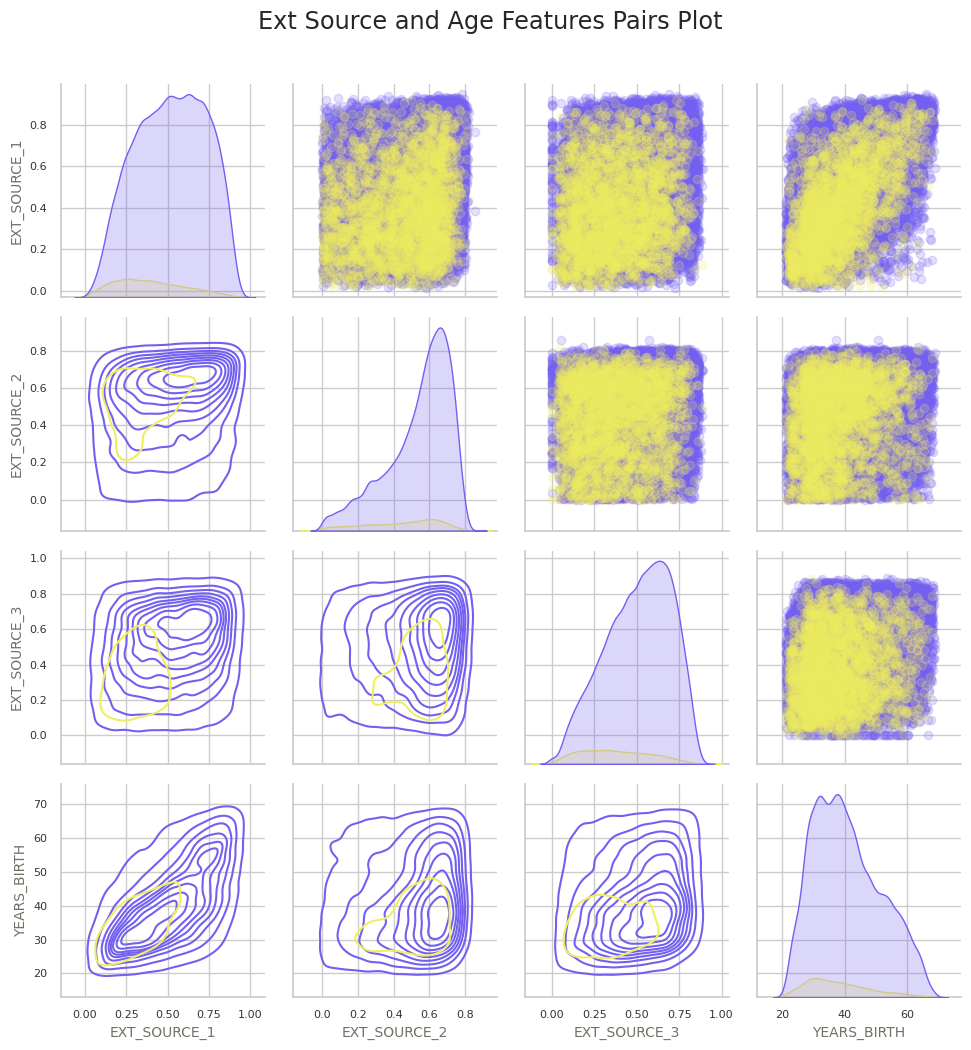

In [38]:
# Copy the data for plotting
plot_data = ext_data.drop(columns = ['DAYS_BIRTH']).copy()

# Add in the age of the client in years
plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

# Drop na values and limit to first 100000 rows
plot_data = plot_data.dropna().loc[:100000, :]

# Function to calculate correlation coefficient between two columns
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

custom_colors = ["#7360F0", "#F0EE60"]
n_levels = len(plot_data['TARGET'].unique())
cmap = mcolors.ListedColormap(custom_colors * (n_levels // len(custom_colors) + 1))

# Create the pairgrid object
grid = sns.PairGrid(data=plot_data, diag_sharey=False,
                    hue='TARGET',
                    vars=[x for x in list(plot_data.columns) if x != 'TARGET'],
                    palette=cmap(np.linspace(0, 1, n_levels)),
                    hue_order=sorted(plot_data['TARGET'].unique()))

# Upper is a scatter plot
grid.map_upper(plt.scatter, alpha = 0.2)

# Diagonal is a histogram
grid.map_diag(sns.kdeplot, fill=True)

# Bottom is density plot
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);

plt.suptitle('Ext Source and Age Features Pairs Plot', y = 1.05);
plt.show()
plt.close()

Dans ce graphique, le jaune indique les prêts non remboursés et le bleu les prêts remboursés. Nous pouvons voir les différentes relations au sein des données. Il semble y avoir une relation linéaire positive modérée entre `EXT_SOURCE_1` et `DAYS_BIRTH` (ou équivalemment `YEARS_BIRTH`), ce qui indique que cette caractéristique peut prendre en compte l'âge du client.

# Baseline

Pour une base naïve, nous pourrions deviner la même valeur pour tous les exemples de l'ensemble de test.  On nous demande de prédire la probabilité de ne pas rembourser le prêt, donc si nous ne sommes pas du tout sûrs, nous devrions deviner 0,5 pour toutes les observations de l'ensemble de test. Nous obtiendrons ainsi une aire sous la courbe de la caractéristique de fonctionnement du récepteur (AUC ROC) de 0,5 dans la compétition. ([une tâche de classification au hasard obtiendra un score de 0,5](https://stats.stackexchange.com/questions/266387/can-auc-roc-be-between-0-0-5)).

Comme nous savons déjà quel score nous allons obtenir, nous n'avons pas vraiment besoin de faire une estimation naïve de la base de référence. Utilisons un modèle légèrement plus sophistiqué pour notre base de référence réelle : La régression logistique.

## Données "brutes"

Pour obtenir une base de référence, nous utiliserons toutes les caractéristiques après avoir encodé les variables catégorielles. Nous allons prétraiter les données en remplissant les valeurs manquantes (imputation) et en normalisant la gamme des caractéristiques (mise à l'échelle des caractéristiques). Le code suivant exécute ces deux étapes de prétraitement.

In [39]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

# Drop the target from the training data
if 'TARGET' in app_train:
    train = app_train.drop(columns=['TARGET','SK_ID_CURR'])
else:
    train = app_train.copy()

# Feature names
features = list(train.columns)

# Copy of the testing data
test = app_test.drop(columns=['SK_ID_CURR']).copy()

# Median imputation of missing values
imputer = SimpleImputer(strategy='median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit on the training data
imputer.fit(train)

# Transform both training and testing data
train_imputed = imputer.transform(train)
test_imputed = imputer.transform(test)

# Convert the imputed data back to DataFrame to keep column names
train_imputed_df = pd.DataFrame(train_imputed, columns=features)
test_imputed_df = pd.DataFrame(test_imputed, columns=features)

# Repeat with the scaler
scaler.fit(train_imputed_df)
train_scaled = scaler.transform(train_imputed_df)
test_scaled = scaler.transform(test_imputed_df)

# Convert the scaled data back to DataFrame to keep column names
train_scaled_df = pd.DataFrame(train_scaled, columns=features)
test_scaled_df = pd.DataFrame(test_scaled, columns=features)

print('Training data shape:', train_scaled_df.shape)
print('Testing data shape:', test_scaled_df.shape)

Training data shape: (307511, 239)
Testing data shape: (48744, 239)


Les données d'entraînements sont ensuite transformer en dataframe afin d'y ajouter les colonne `TARGET` en vu des tests de modélisations.

In [40]:
train_scaled_df['TARGET'] = app_train['TARGET']
train_scaled_df['SK_ID_CURR'] = app_train['SK_ID_CURR']
train_scaled_df.set_index('SK_ID_CURR', inplace=True)

In [41]:
test_imputed_df['SK_ID_CURR'] = app_test['SK_ID_CURR']
test_imputed_df.set_index('SK_ID_CURR', inplace=True)

### Export des données

In [42]:
test_imputed_df.to_csv('/content/drive/MyDrive/OC_Data_Scientist/P7_Implémentez_un_modèle_de_scoring/test_imputed_df_api.csv', sep=';')
test_imputed_df.sample(n=20).to_csv('/content/drive/MyDrive/OC_Data_Scientist/P7_Implémentez_un_modèle_de_scoring/test_imputed_df_api_20.csv', sep=';')

In [43]:
train_imputed_df['TARGET'] = app_train['TARGET']
train_imputed_df['SK_ID_CURR'] = app_train['SK_ID_CURR']
train_imputed_df.set_index('SK_ID_CURR', inplace=True)

In [44]:
train_imputed_df.to_csv('/content/drive/MyDrive/OC_Data_Scientist/P7_Implémentez_un_modèle_de_scoring/train_imputed_df_api.csv', sep=';')
train_imputed_df.sample(n=20).to_csv('/content/drive/MyDrive/OC_Data_Scientist/P7_Implémentez_un_modèle_de_scoring/train_imputed_df_api_20.csv', sep=';')

### Entraînement des modèles

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/remi.rogulski/OC-projet7/e/OC-135
Scaler enregistré localement sous /content/drive/MyDrive/OC_Data_Scientist/P7_Implémentez_un_modèle_de_scoring/models/scaler_307511_rawdata_rfe_dill_v1_LogisticRegression-[24-10-25 at 18:27].dill
########################################
[RFECV - LogisticRegression in progress]
Fitting estimator with 239 features.
Fitting estimator with 238 features.
Fitting estimator with 237 features.
Fitting estimator with 236 features.
Fitting estimator with 235 features.
Fitting estimator with 234 features.
Fitting estimator with 233 features.
Fitting estimator with 232 features.
Fitting estimator with 231 features.
Fitting estimator with 230 features.
Fitting estimator with 229 features.
Fitting estimator with 228 features.
Fitting estimator with 227 features.
Fitting estimator with 226 features.
Fitting estimator with 225 features.
Fitting estimator with 224 features.
Fitting estimat

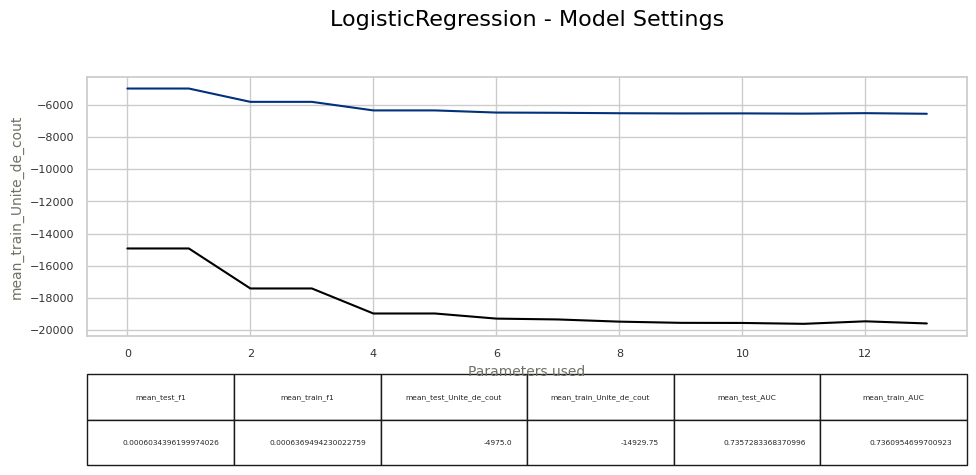

Meilleurs résultats obtenus par le modèle LogisticRegression
----------
[Best Score (Unite_de_cout) -> -4975.0]
[Controle Unite_de_cout -> -5037]
[Score f1 -> 0.0006]
[Controle Score f1 -> 0.0006]
[Score AUC -> 0.7357]
[Controle Score AUC -> 0.7361]
----------
[Best Score TunedThreshold (Unite_de_cout) -> -3975.2]
[Controle TunedThreshold Unite_de_cout -> 0.9195]
TunedThreshold best seuil: 0.9


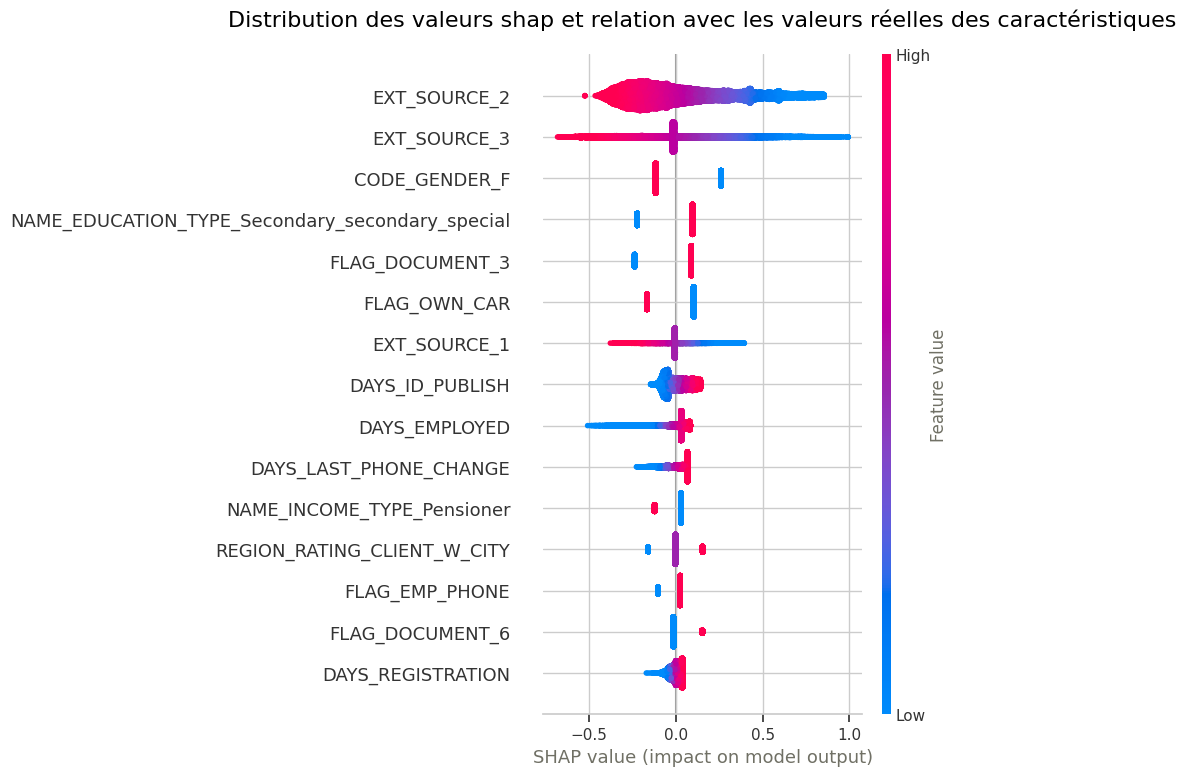

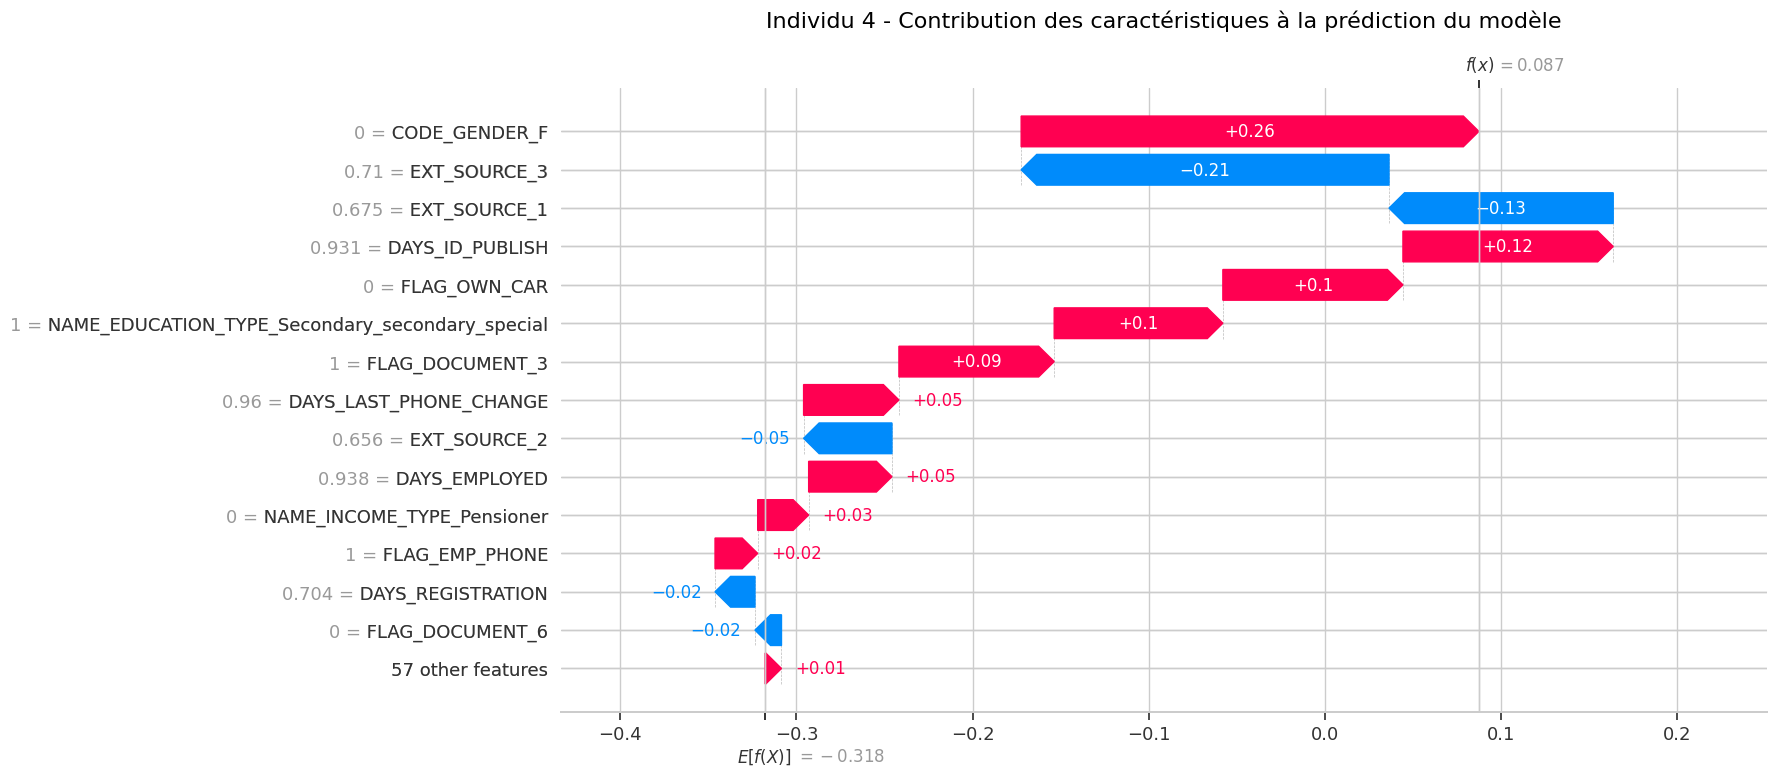

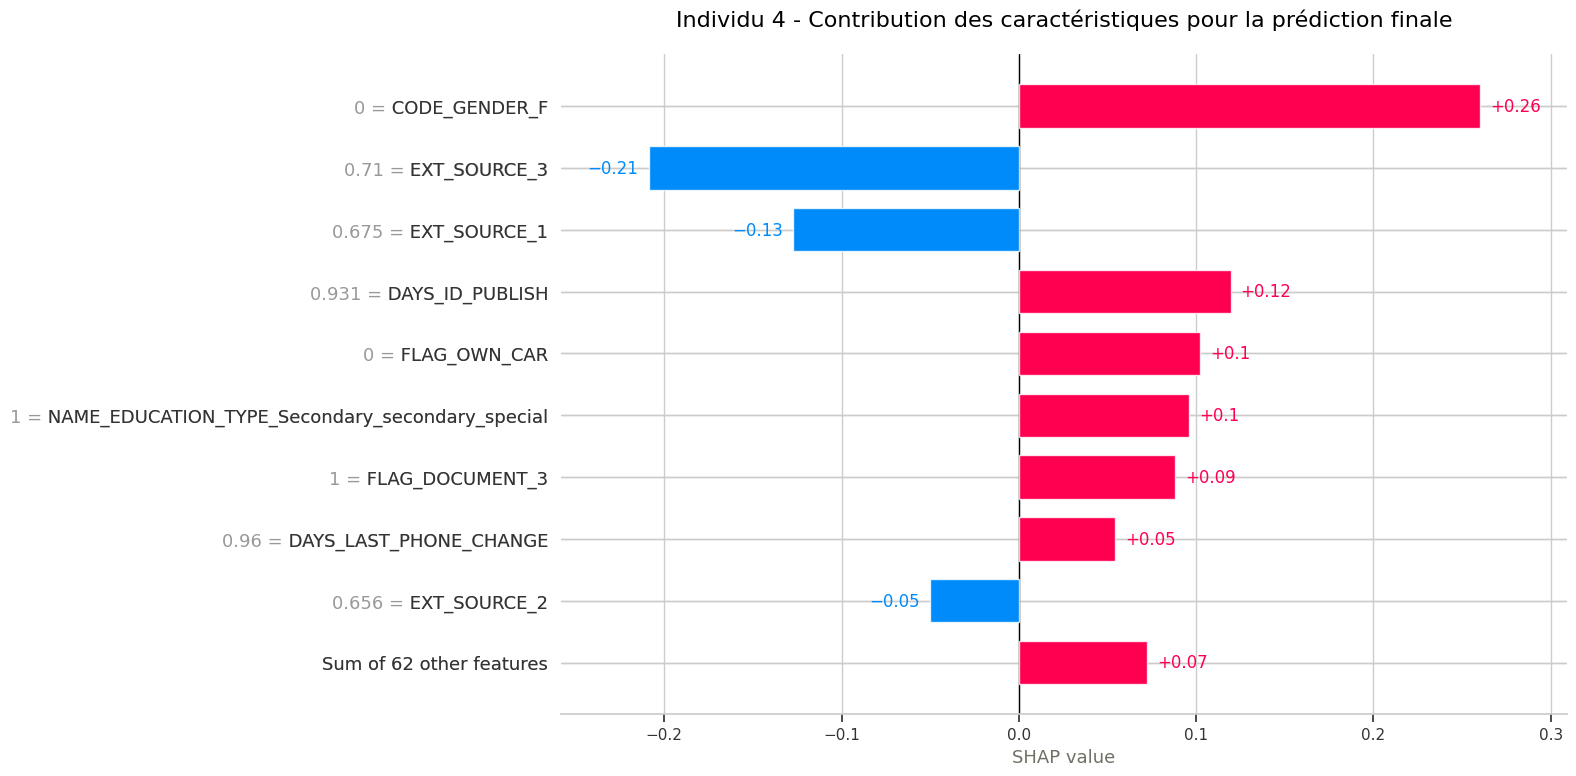

<Figure size 640x480 with 0 Axes>

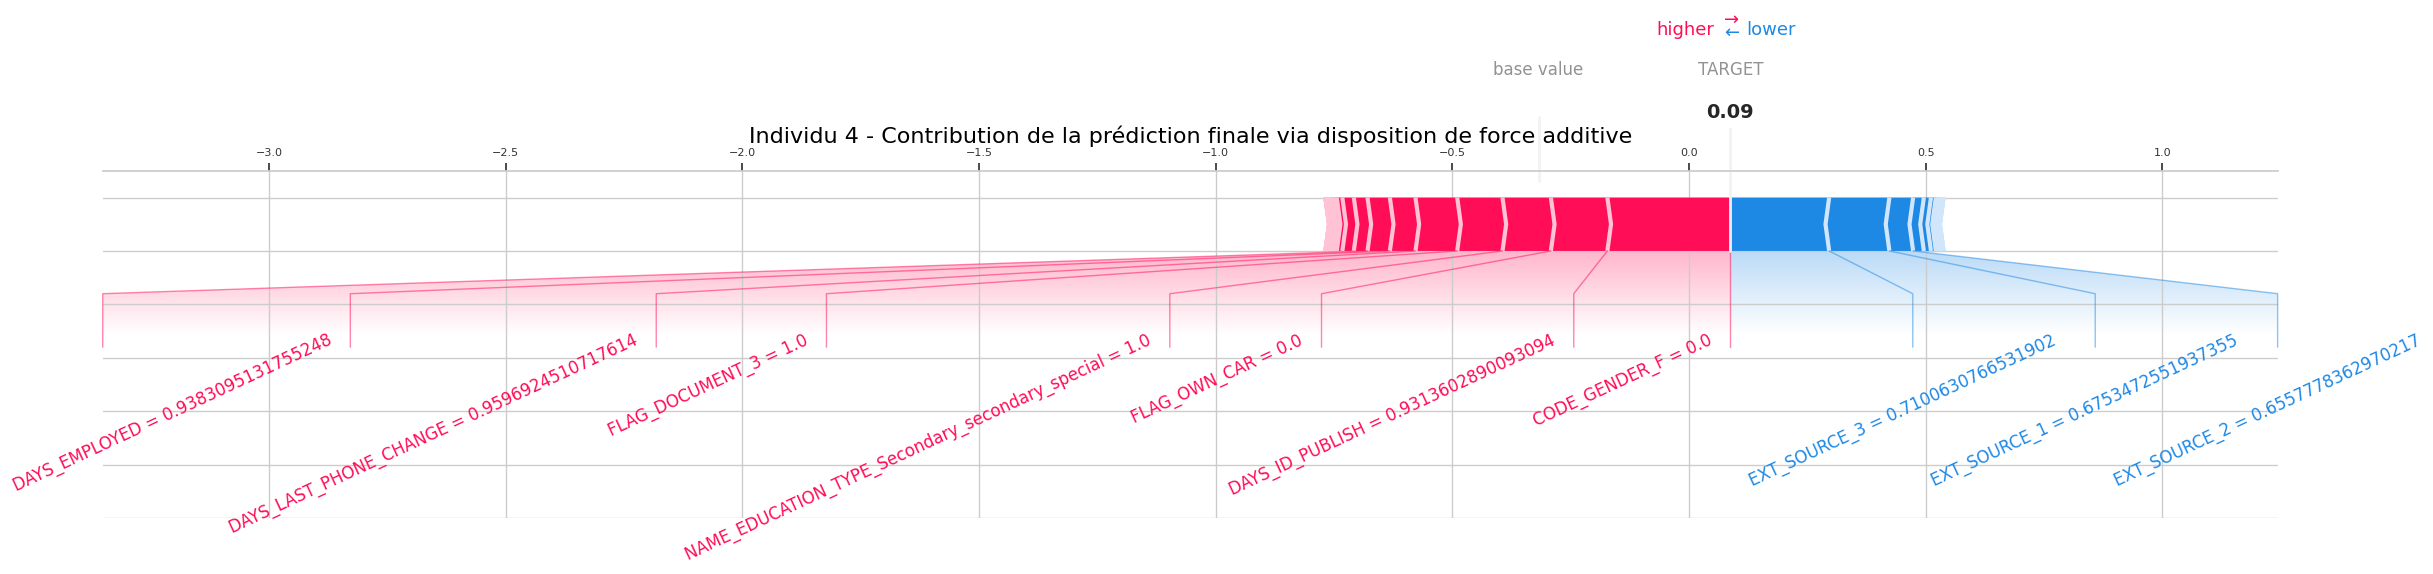

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 2 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 2 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/remi.rogulski/OC-projet7/e/OC-135/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/remi.rogulski/OC-projet7/e/OC-136
Scaler enregistré localement sous /content/drive/MyDrive/OC_Data_Scientist/P7_Implémentez_un_modèle_de_scoring/models/scaler_307511_rawdata_rfe_dill_v1_LGBM-[24-10-25 at 19:17].dill
########################################
[RFECV - LGBM in progress]
Fitting estimator with 239 features.
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.355094 seconds.
You can set `fo

<Figure size 640x480 with 0 Axes>

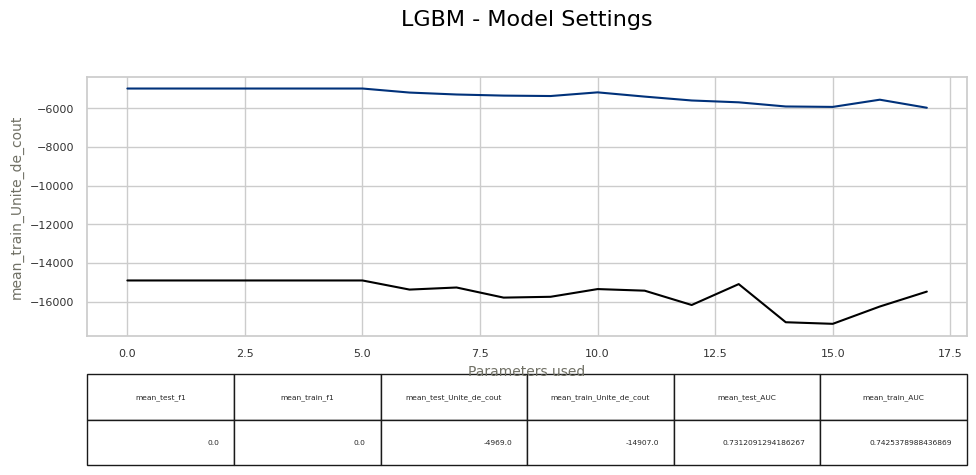

Meilleurs résultats obtenus par le modèle LGBM
----------
[Best Score (Unite_de_cout) -> -4969.0]
[Controle Unite_de_cout -> -4949]
[Score f1 -> 0.0]
[Controle Score f1 -> 0.0]
[Score AUC -> 0.7312]
[Controle Score AUC -> 0.7425]
----------
[Best Score TunedThreshold (Unite_de_cout) -> -3975.2]
[Controle TunedThreshold Unite_de_cout -> 0.9195]
TunedThreshold best seuil: 0.8


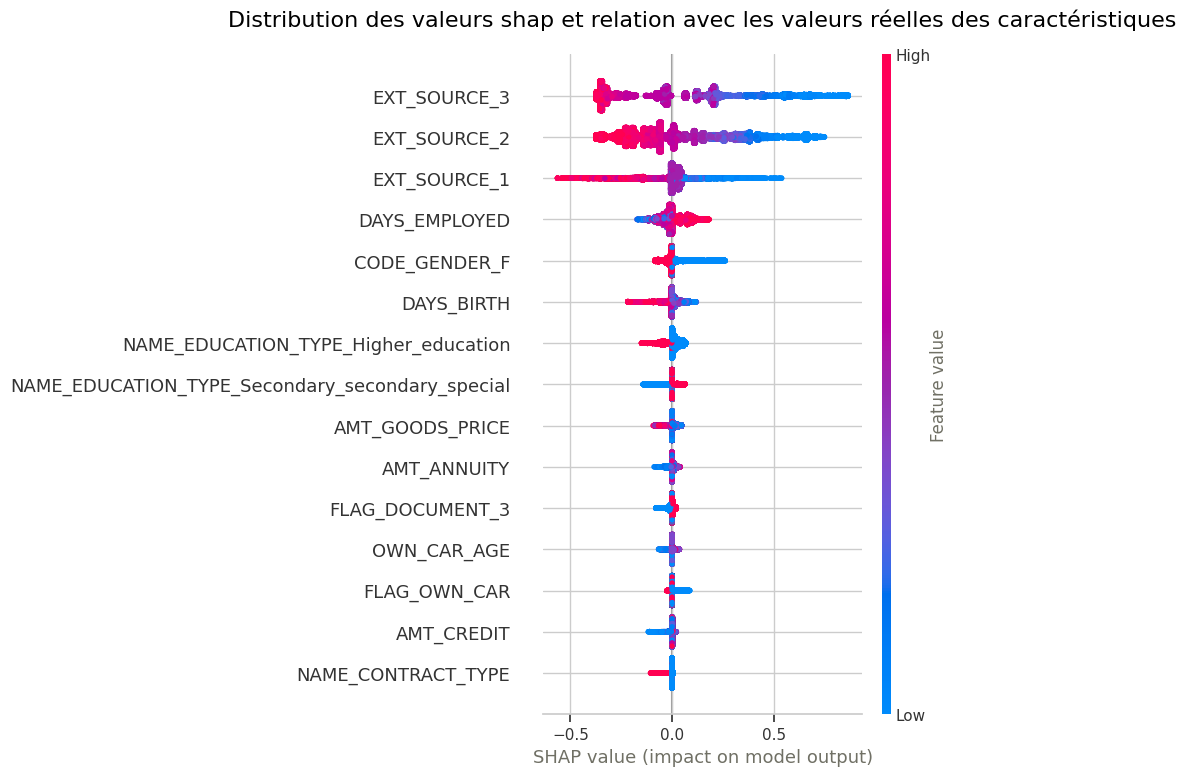

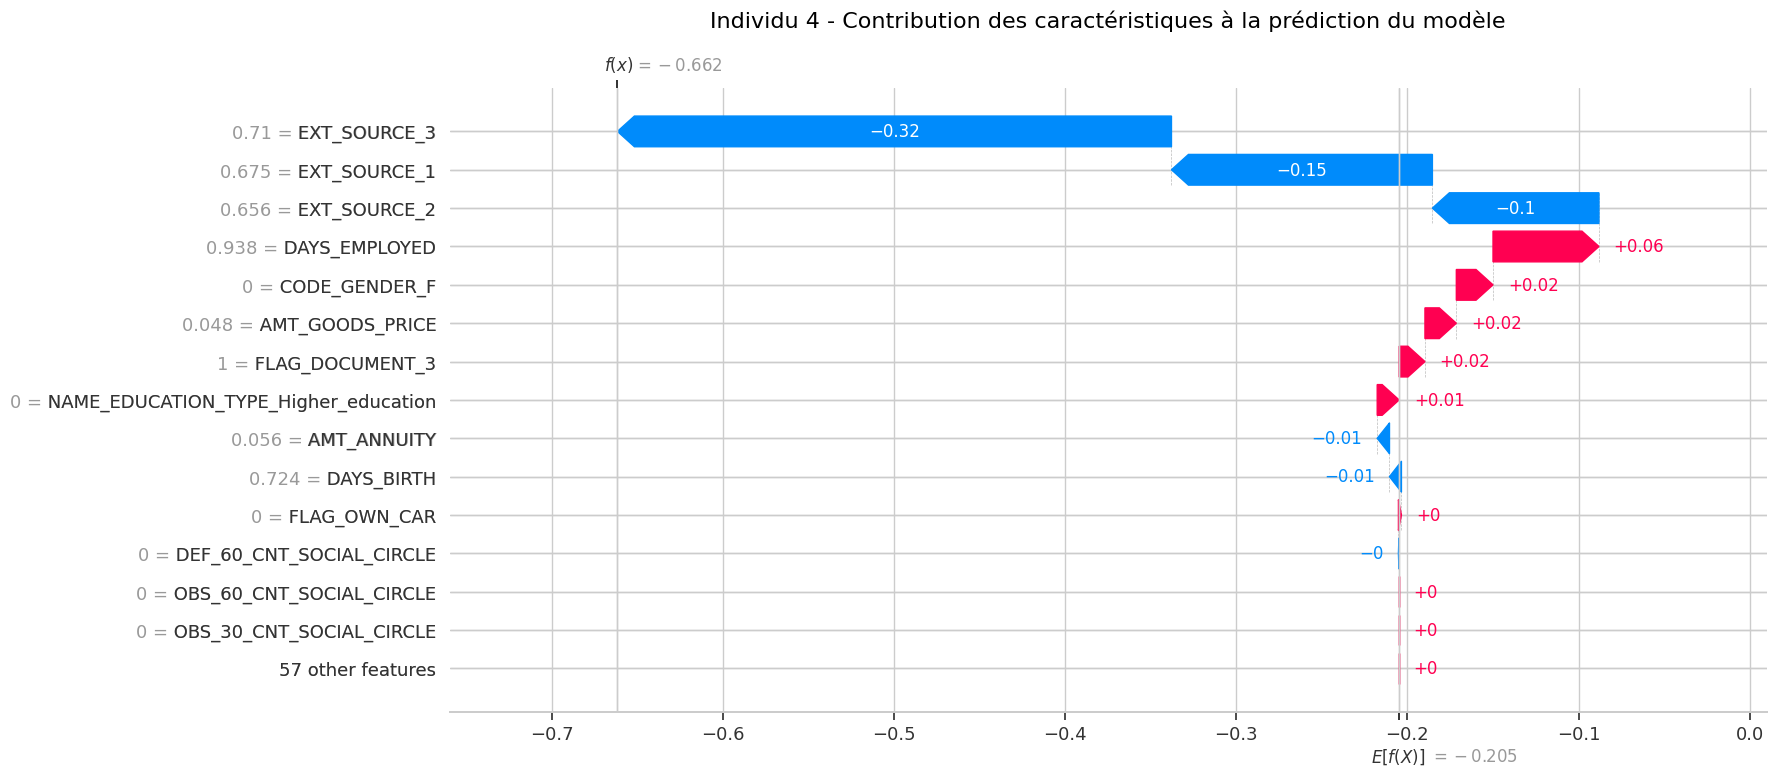

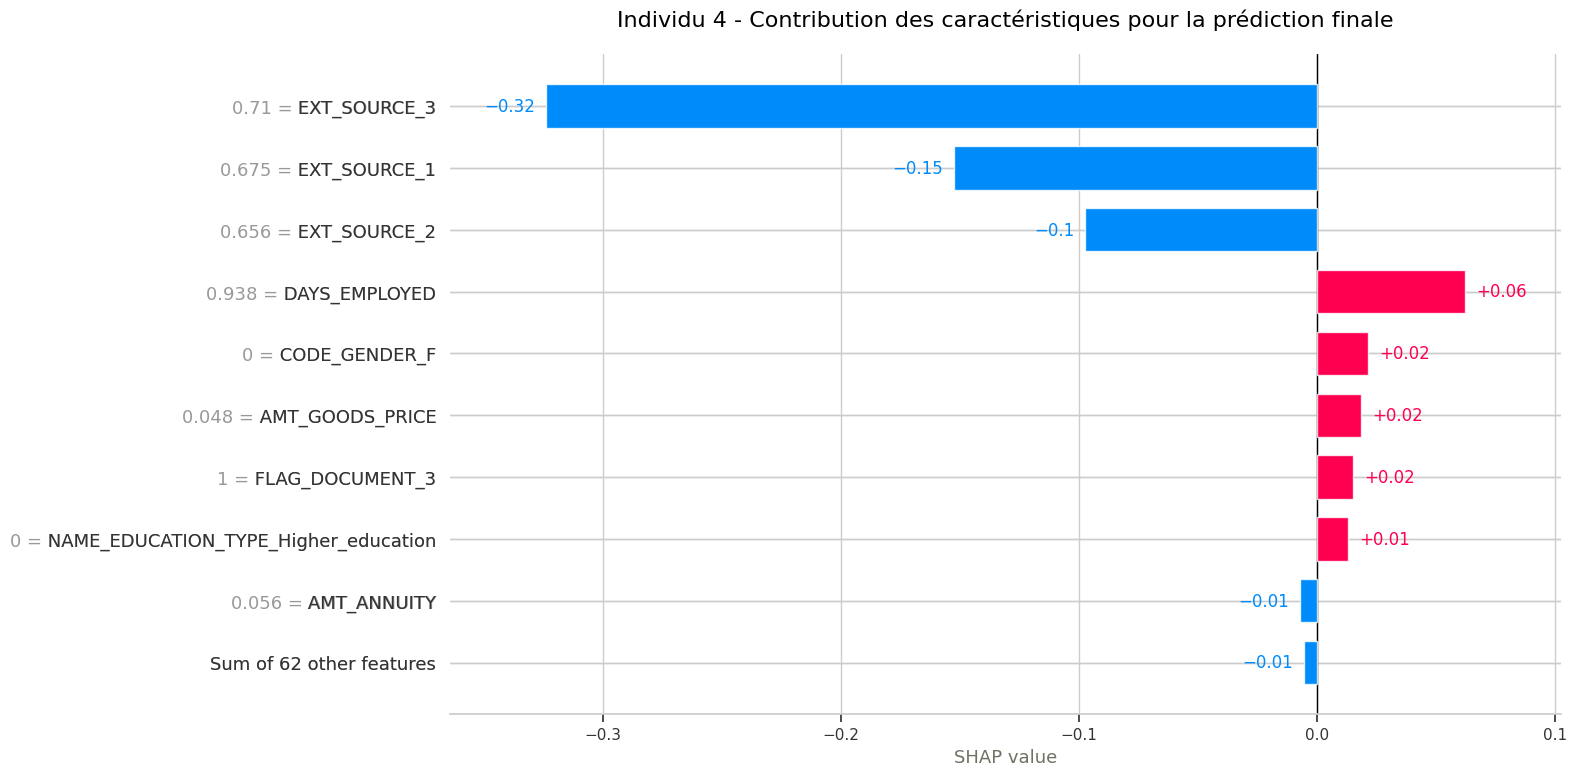

<Figure size 640x480 with 0 Axes>

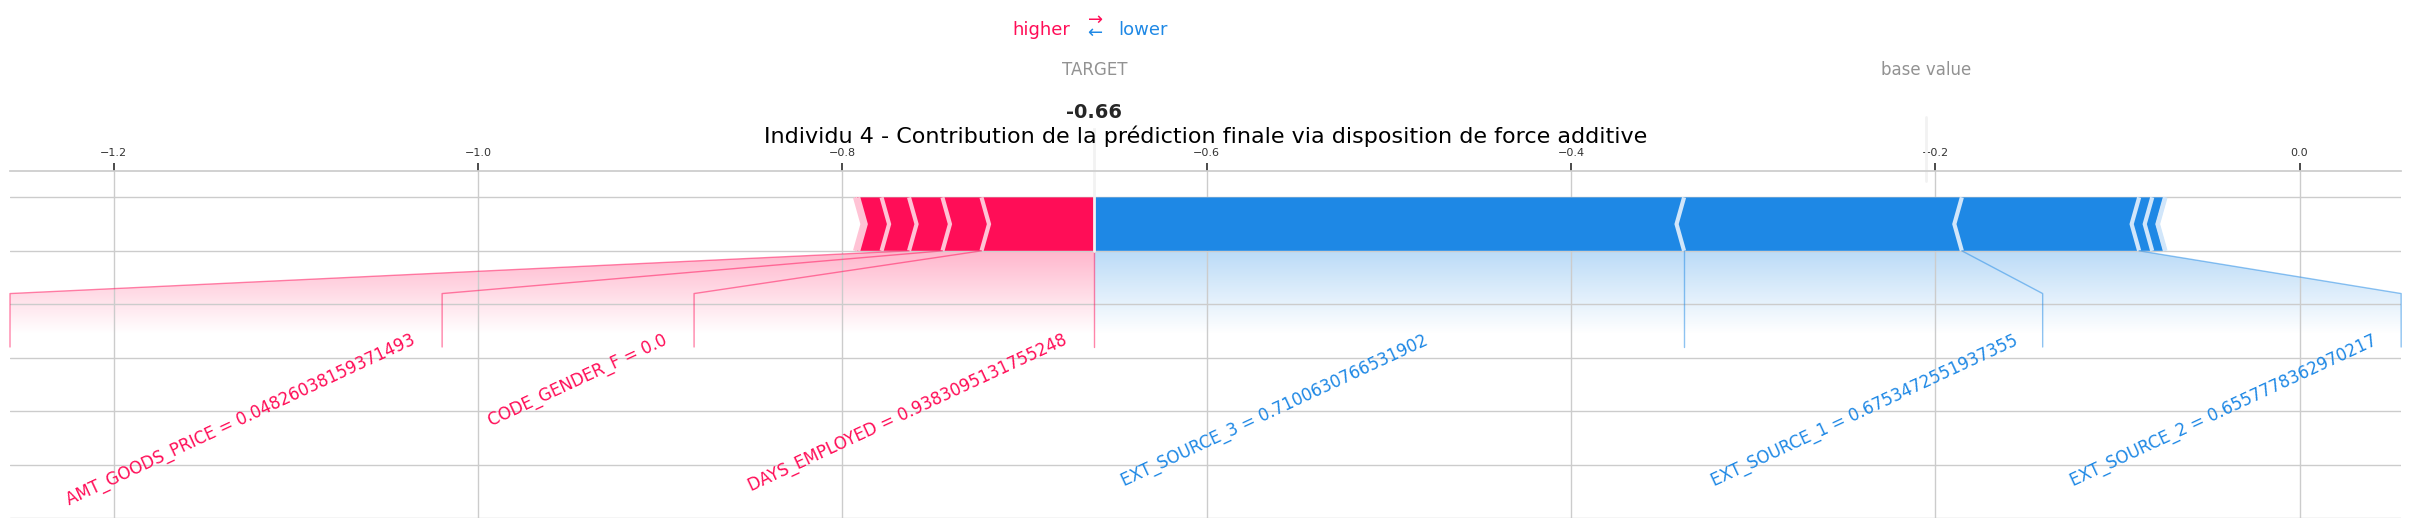

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/remi.rogulski/OC-projet7/e/OC-136/metadata


<Figure size 640x480 with 0 Axes>

In [53]:
import sys
import os

# Ajouter le répertoire courant au sys.path
module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Entrainement des modèles
X_train_raw, X_test_raw, y_train_raw, y_test_raw, scaler, rfe, model_threshold, model, explainer = MF.train_models(train_scaled_df, scaler, 'rawdata_rfe_dill_v1')

## Data Drift

In [47]:
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset

# random_columns = app_train.sample(n=10, axis=1, random_state=42).columns.to_list()

# Analyse du Data Drift avec Evidently
data_drift_report = Report(metrics=[DataDriftPreset(),])
data_drift_report.run(current_data=app_test, reference_data=app_train.drop(columns='TARGET'), column_mapping=None)
# Sauvegarde du rapport
file_path = '/content/drive/MyDrive/OC_Data_Scientist/P7_Implémentez_un_modèle_de_scoring/reports'
data_drift_report.save(f"{file_path}/rapport_data_drift.html")

# Affichage du rapport de Data Drift
data_drift_report.show()

Output hidden; open in https://colab.research.google.com to view.

# Conclusions

Dans ce carnet, nous avons vu comment démarrer avec une compétition Kaggle d'apprentissage automatique. Nous nous sommes d'abord assurés de bien comprendre les données, notre tâche et la métrique sur laquelle nos soumissions seront jugées. Ensuite, nous avons effectué une EDA assez simple pour essayer d'identifier les relations, les tendances ou les anomalies qui pourraient aider notre modélisation. En cours de route, nous avons effectué les étapes de prétraitement nécessaires, telles que le codage des variables catégorielles, l'imputation des valeurs manquantes et la mise à l'échelle des caractéristiques. Ensuite, nous avons construit de nouvelles caractéristiques à partir des données existantes pour voir si cela pouvait aider notre modèle.

Une fois l'exploration des données, la préparation des données et l'ingénierie des caractéristiques terminées, nous avons mis en œuvre un modèle de base que nous espérons améliorer. Nous avons ensuite construit un deuxième modèle légèrement plus compliqué afin de battre notre premier score. Nous avons également réalisé une expérience pour déterminer l'effet de l'ajout de variables d'ingénierie.